In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.hparams_S4G import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Fri Mar 12 18:36:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.04    Driver Version: 455.23.04    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:19:00.0 Off |                  N/A |
| 79%   67C    P2   301W / 370W |  13261MiB / 24268MiB |     94%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:68:00.0 Off |                  N/A |
| 76%   

In [4]:
from parallel_wavegan.utils import download_pretrained_model
from parallel_wavegan.utils import load_model

device='cuda'
vocoder_tag = "ljspeech_parallel_wavegan.v3"

# NOTE: Sometimes download is failed due to "Permission denied". That is 
#   the limitation of google drive. Please retry after serveral hours.
vocoder = load_model(download_pretrained_model(vocoder_tag)).to(device).eval()
vocoder.remove_weight_norm()
print('done')

from parallel_wavegan.utils import read_hdf5

stats_filename = "/home/scpark/.cache/parallel_wavegan/ljspeech_parallel_wavegan.v3/stats.h5"
mean = read_hdf5(stats_filename, 'mean')
scale = read_hdf5(stats_filename, 'scale')
print('done')

done
done


In [3]:
save_dir = 'save/model_S4G'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [4]:
!ls $save_dir

data.json  save_10000  save_20000  save_30000  save_40000  save_5000
save_0	   save_15000  save_25000  save_35000  save_44298  save_825


In [5]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=tts_hparams.lr, weight_decay=tts_hparams.weight_decay)

step = 44298

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"MelEncoder size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if True:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 243.8MiB
TTS size 156.2MiB
MelEncoder size 52.3MiB
MelDecoder size 94.9MiB
loaded : 44298
44298
done


In [6]:
trainset = LJDataset(tts_hparams)
collate_fn = TextMelCollate(tts_hparams)
train_loader = torch.utils.data.DataLoader(trainset, num_workers=8, #tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(train_loader)

validset = LJDataset(tts_hparams, split='valid')
valid_loader = torch.utils.data.DataLoader(validset, num_workers=tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(valid_loader)

testset = LJDataset(tts_hparams, split='test')
test_loader = torch.utils.data.DataLoader(testset, num_workers=1, 
                          shuffle=False, sampler=None, batch_size=1, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(test_loader)

In [7]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

elapsed time : 0.059618782997131345


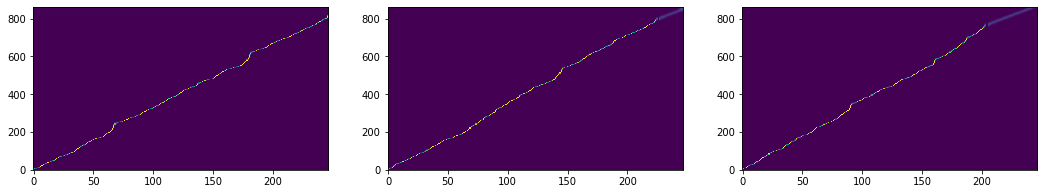

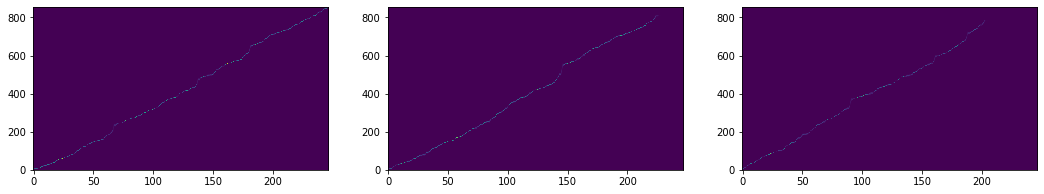

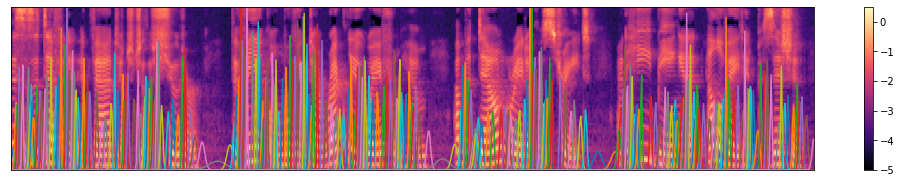

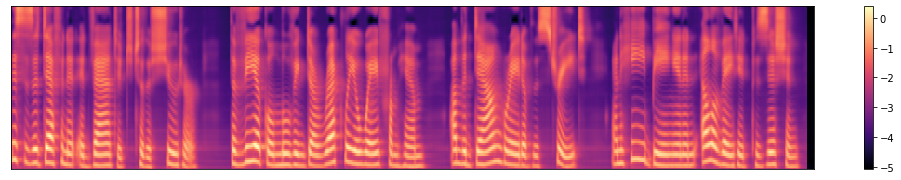

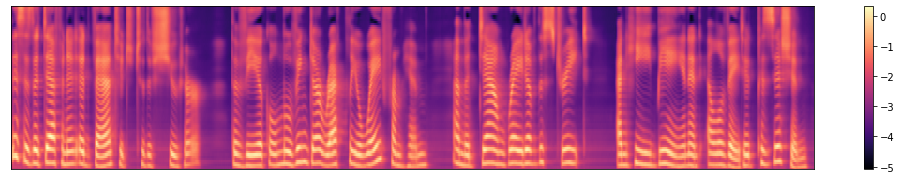

tensor(0.2114, device='cuda:0')
step : 44501 stt : 0.0027 tts : 0.1474 recon : 0.0344 kl : 0.0124 beta : 0.8901
tensor(0.1756, device='cuda:0')
step : 44502 stt : 0.0020 tts : 0.1293 recon : 0.0278 kl : 0.0110 beta : 0.8902
tensor(0.2167, device='cuda:0')
step : 44503 stt : 0.0021 tts : 0.1210 recon : 0.0278 kl : 0.0109 beta : 0.8902
tensor(0.1947, device='cuda:0')
step : 44504 stt : 0.0026 tts : 0.1426 recon : 0.0298 kl : 0.0118 beta : 0.8902
tensor(0.2314, device='cuda:0')
step : 44505 stt : 0.0021 tts : 0.1181 recon : 0.0252 kl : 0.0104 beta : 0.8902
tensor(0.1919, device='cuda:0')
step : 44506 stt : 0.0016 tts : 0.1239 recon : 0.0266 kl : 0.0108 beta : 0.8902
tensor(0.1863, device='cuda:0')
step : 44507 stt : 0.0028 tts : 0.1343 recon : 0.0287 kl : 0.0114 beta : 0.8903
tensor(0.1631, device='cuda:0')
step : 44508 stt : 0.0020 tts : 0.1359 recon : 0.0287 kl : 0.0113 beta : 0.8903
tensor(0.2082, device='cuda:0')
step : 44509 stt : 0.0014 tts : 0.1404 recon : 0.0300 kl : 0.0117 beta :

tensor(0.2166, device='cuda:0')
step : 44575 stt : 0.0029 tts : 0.1351 recon : 0.0296 kl : 0.0116 beta : 0.8916
tensor(0.1727, device='cuda:0')
step : 44576 stt : 0.0015 tts : 0.1207 recon : 0.0265 kl : 0.0106 beta : 0.8916
tensor(0.1535, device='cuda:0')
step : 44577 stt : 0.0018 tts : 0.1395 recon : 0.0274 kl : 0.0110 beta : 0.8917
tensor(0.1846, device='cuda:0')
step : 44578 stt : 0.0026 tts : 0.1450 recon : 0.0308 kl : 0.0119 beta : 0.8917
tensor(0.1391, device='cuda:0')
step : 44579 stt : 0.0012 tts : 0.1326 recon : 0.0278 kl : 0.0114 beta : 0.8917
tensor(0.1406, device='cuda:0')
step : 44580 stt : 0.0014 tts : 0.1340 recon : 0.0271 kl : 0.0111 beta : 0.8917
tensor(0.1971, device='cuda:0')
step : 44581 stt : 0.0024 tts : 0.1252 recon : 0.0301 kl : 0.0119 beta : 0.8917
tensor(0.1682, device='cuda:0')
step : 44582 stt : 0.0013 tts : 0.1300 recon : 0.0295 kl : 0.0115 beta : 0.8918
tensor(0.1306, device='cuda:0')
step : 44583 stt : 0.0013 tts : 0.1307 recon : 0.0278 kl : 0.0110 beta :

In [ ]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

model.train()

while(True):
    
    for batch in train_loader:
        batch = to_cuda(batch)
        
        model.train()
        model.increase_step()
        model.zero_grad()

        stt_outputs, tts_outputs = model(batch)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item(),
                  'beta :', '%0.4f' % model.beta)
                  
            
        if step % 100 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', model.beta)    
            
        if step % 100 == 0:
            display.clear_output()
            
            index = 0
            model.eval()
            
            with torch.no_grad():
                times = []
                for _ in range(10):
                    t0 = time.time()
                    samples, _ = model.inference(batch['text'], batch['mels'].size(2), stt_outputs["alignments"], temperature=1.0)
                    t1 = time.time()
                    times.append(t1 - t0)
                times = np.array(times)
                print('elapsed time :', np.mean(times))

            try:
                _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
                batch_size = _tts_alignments.shape[0]
                plt.figure(figsize=[18, 3])
                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
                plt.show()

                _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
                batch_size = _stt_alignments.shape[0]
                plt.figure(figsize=[18, 3])
                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
                plt.show()

                plt.figure(figsize=[18, 3])
                _x = batch['mels'].data.cpu().numpy()
                librosa.display.specshow(_x[index])
                plt.colorbar()

                for i in range(_stt_alignments.shape[1]):
                    plt.plot(_stt_alignments[index, i] * 100)

                plt.show()

                plt.figure(figsize=[18, 3])
                _y = tts_outputs['pred'].data.cpu().numpy()
                librosa.display.specshow(_y[index])
                plt.colorbar()
                plt.show()

                plt.figure(figsize=[18, 3])
                _s = samples.data.cpu().numpy()
                librosa.display.specshow(_s[index, :, :_y.shape[2]])
                plt.colorbar()
                plt.show()
            except:
                pass
                      
        step += 1
        

In [63]:
logger.save(step, model, optimizer)

saved save/model_S4G/save_44298


The auditors were paid a shilling each for their services each time the poor-box was opened. The steward was also remunerated for his trouble.
torch.Size([1, 80, 751]) 0.01864492893218994
{'alignment': 0.004446983337402344, 'random': 0.00019121170043945312, 'last_conv': 0.005681037902832031, 'z_proj': 0.0001347064971923828, 'cond': 0.0007524490356445312, 'up': 0.0009126663208007812, 'encode': 0.004335880279541016, 'pad': 2.8133392333984375e-05, 'enc_conv': 0.0009267330169677734, 'enc_lstm': 0.003209352493286133}


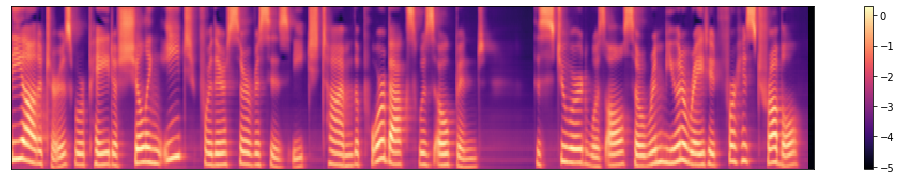

In [61]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 

for i, batch in enumerate(test_loader):
    batch = to_cuda(batch)
    if i == 25:
        break
print(batch['strings'][0])

model.eval()
with torch.no_grad():
    index = 0
    times = []
    for _ in range(10):
        t0 = time.time()
        samples, time_dict = model.inference(batch['text'][0:1], None, None, temperature=1.0, clip=2)
        t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    print(samples.shape, np.mean(times))
    print(time_dict)
    
    plt.figure(figsize=[18, 3])
    _x = batch['mels'].data.cpu().numpy()
    _s = samples.data.cpu().numpy()
    librosa.display.specshow(_s[index])
    plt.colorbar()
    plt.show()

In [62]:
vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)

(192256,)
